Title: The Self-Organizing Map Algorithm
Author: Thomas Breuel
Institution: UniKL

In [72]:

from scipy import *
from pylab import *
import tables
def showgrid(data,c=10,r=None):
    if r is None: r = (len(data)+c-1)//c
    for i in range(min(r*c,len(data))):
        subplot(r,c,i+1)
        w = int(sqrt(len(data[i])))
        imshow(data[i].reshape(w,w))

# Reading MNIST

In [73]:
with tables.openFile("mnist.h5") as db:
    print db
    images = array(db.root.deskewed[:50000])
    labels = array(db.root.labels[:50000])

mnist.h5 (File) ''
Last modif.: 'Tue Jun  5 10:16:56 2012'
Object Tree: 
/ (RootGroup) ''
/deskewed (EArray(60000, 28, 28), shuffle, zlib(9)) ''
/images (CArray(60000, 28, 28), shuffle, zlib(9)) ''
/labels (CArray(60000,), shuffle, zlib(9)) ''
/test_deskewed (EArray(10000, 28, 28), shuffle, zlib(9)) ''
/test_images (CArray(10000, 28, 28), shuffle, zlib(9)) ''
/test_labels (CArray(10000,), shuffle, zlib(9)) ''



In [74]:
# showing a sample
gray()
figsize(10,10)
showgrid(data,10,10)

In [75]:
# reshaping into data vectors
hw = images.shape[1:]
data = images.reshape(len(images),prod(hw))

Self-Organizing Map
===================

Self-organizing maps are similar to k-means algorithms: they take in
a set of data points and generate a set of cluster centers.

But there is an additional constraint on the cluster centers:
they are assumed to be laid out on a 2D grid, and the cost function
that we are optimizing takes this into account.

(k-means cost function)

We can think of $k$-means as optimizing a cost function via EM or gradient descent.

For k-means, our cost function is:

$$ E = \sum_i ||x_i-\mu_{c(x)}||^2 $$

Here, $\mu_{c(x)}$ is the center closest to the training vector $x$.

(SOM cost function)

With the self-organizing map, we modify this slightly:

$$ E = \sum_i ~~~ \sum_j ~~~ \alpha(j,c(x)) ~~~~ ||x_i-\mu_j||^2 $$

Here, $c(x) = \arg\min ||x-\mu_j||$

If we choose $\alpha(j,c(x)) = \delta(j,c(x))$ then we get the regular $k$-means algorithm.

If we choose $\alpha(j,c(x)) = \delta(j,c(x)) + \beta \left\lfloor d(j,c(x))\leq 1 \right\rfloor$,
where $d(j,c(x))$ is the distance between the closest matching $\mu_c$ and $j$, then we
get the self-organizing map (SOM).

(gradient descent)

In the SOM, we require each vector not just to be close to its closest center, but also
to neighboring centers.

(You can derive the update rules from these cost functions yourself.)

In [76]:

import random as pyrandom
print data.shape

(50000, 784)


In [77]:
# starting with a random sample of prototypes
protos = array(pyrandom.sample(data,100))
protos.shape = (100,784)

The prototypes have a $10\times 10$ grid structure, but for other purposes, we just number them $0...99$.
This function converts between the two views.



In [78]:
def I(i,j): return i*10+j

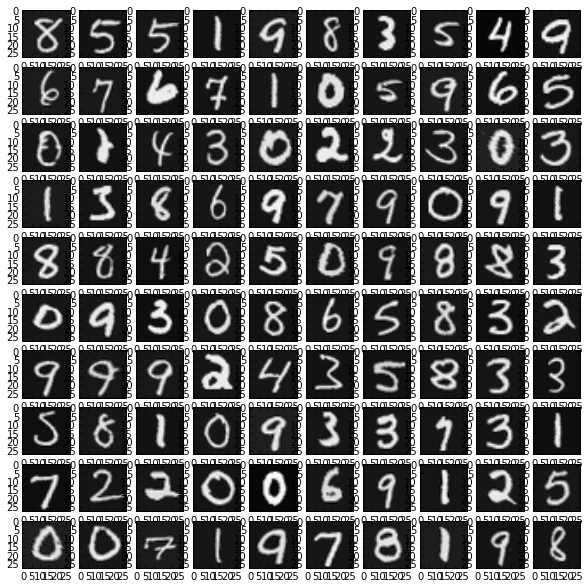

In [79]:
showgrid(protos,10,10)

Let's define `argmindist2` because the index calculations require some more complicated reshaping.



In [80]:
from scipy.spatial.distance import cdist

def argmindist2(x,protos):
    ds = cdist(x.reshape(1,784),protos.reshape(100,784))
    return argmin(ds[0])

Quick check: the closest prototype to prototype 17 should be... prototype 17.



In [81]:
argmindist2(protos[17],protos)

17

The update step updates the best matching prototype and its neighbors
according to the update rule derived from gradient descent minimization
of the error, as defined above.



In [82]:
def update(x,alpha,beta):
    best = argmindist2(x,protos)
    i,j = (best/10,best%10)
    protos[I(i,j)] += alpha*(x-protos[I(i,j)])
    if i>0: protos[I(i-1,j)] += beta*(x-protos[I(i-1,j)])
    if j>0: protos[I(i,j-1)] += beta*(x-protos[I(i,j-1)])    
    if i<9: protos[I(i+1,j)] += beta*(x-protos[I(i+1,j)])
    if j<9: protos[I(i,j+1)] += beta*(x-protos[I(i,j+1)])

In [83]:
# updates
for iter,lalpha in enumerate(linspace(log(0.1),log(0.001),100000)):
    if iter%10000==0: sys.stderr.write(" %d"%iter)
    i = iter%len(data)
    alpha = exp(lalpha)
    update(data[i],alpha,0.3*alpha)

 0 10000 20000 30000 40000 50000 60000 70000 80000 90000

(notes on updates)

As usual, we now perform a lot of gradient descent steps.

The `linspace...log` bit is a convenient way of specifying learning rates:
we want the learning rate to decrease from around 0.1 to around 0.001 as we
continue training.

The learning rate can be thought of as the length of a _moving average_,
and a value of 0.001 says that we want to average over about 1000 updates
to each prototype.

If we now look at the output, we see that we get prototypes or cluster centers,
as we do with k-means, but they are arranged more logically in a grid: similar
prototypes are closer together.



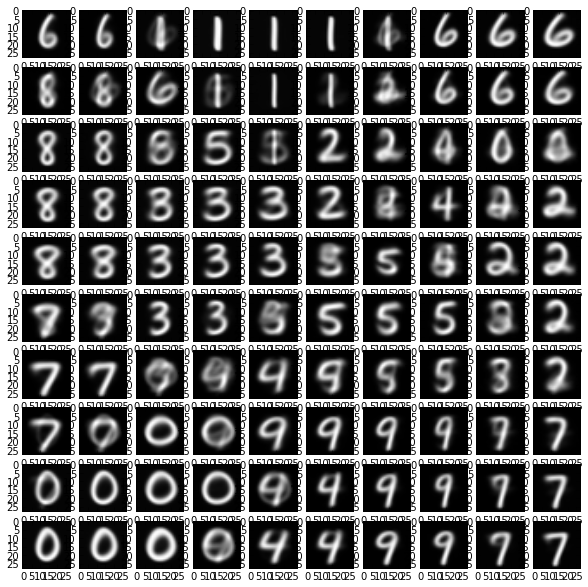

In [84]:
showgrid(protos,10,10)

Let's look at the frequencies of the different clusters.



In [85]:
closest = array([argmindist2(x,protos) for x in data])

In [86]:
counts = array([sum(closest==i) for i in range(100)])
counts = counts*1.0/amax(counts)

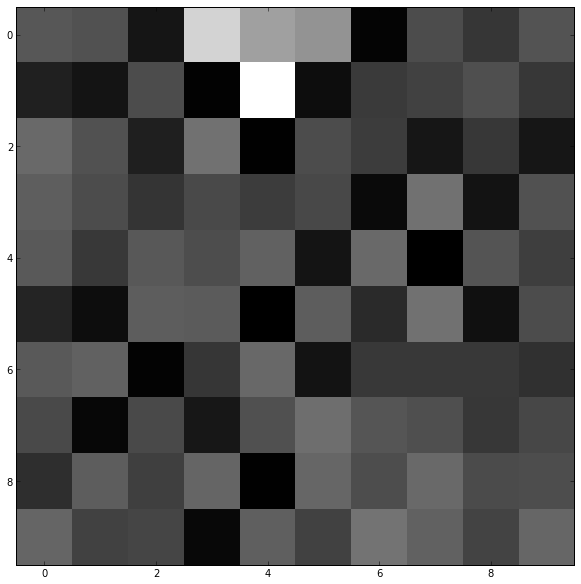

In [87]:
imshow(counts.reshape(10,10),interpolation='nearest')

Let's now display the prototypes of the clusters with intensity
corresponding to the frequency of assigning characters to that cluster.

In [88]:
grid = vstack([hstack([protos.reshape(10,10,28,28)[i,j] for j in range(10)]) for i in range(10)])
scale = vstack([hstack([counts[I(i,j)]*ones((28,28)) for j in range(10)]) for i in range(10)])
imshow(scale*grid)

Try to come up with good visualizations like this when presenting your own research results.

Note that only about 1/3 of all clusters are actually strongly used. This means that in order to get the same quantization you get with $k$-means, you'd need to choose about three times as many cluster centers.

**Homework:** apply this to text files to obtain topic maps.

Toroidal Updates
================

The previous construction causes somewhat distorted maps because
prototypes near the edges of the map have fewer neighbors that those
in the center; this causes "difficult" cases to be moved to the edge.
Often we don't want this, and we define neighborhood somewhat differently.

For the following, note how the `mod` function works in Python:



In [89]:
-1%10

9

Our updates now are "circular", they wrap around at the edges.



In [90]:
def I(i,j): 
    return (i%10)*10+(j%10)

Otherwise, the update rule remains the same.



In [91]:
def update(x,alpha,beta):
    best = argmindist2(x,protos)
    i,j = (best/10,best%10)
    protos[I(i,j)] += alpha*(x-protos[I(i,j)])
    protos[I(i-1,j)] += beta*(x-protos[I(i-1,j)])
    protos[I(i,j-1)] += beta*(x-protos[I(i,j-1)])    
    protos[I(i+1,j)] += beta*(x-protos[I(i+1,j)])
    protos[I(i,j+1)] += beta*(x-protos[I(i,j+1)])

In [92]:
# random initialization
protos = array(pyrandom.sample(data,100))
protos.shape = (100,784)

In [93]:
# random prototypes
showgrid(protos,10,10)

In [94]:
# iterative SOM updates
for iter,lalpha in enumerate(linspace(log(0.1),log(0.001),100000)):
    if iter%10000==0: sys.stderr.write(" %d"%iter)
    i = iter%len(data)
    alpha = exp(lalpha)
    update(data[i],alpha,0.3*alpha)

 0 10000 20000 30000 40000 50000 60000 70000 80000 90000

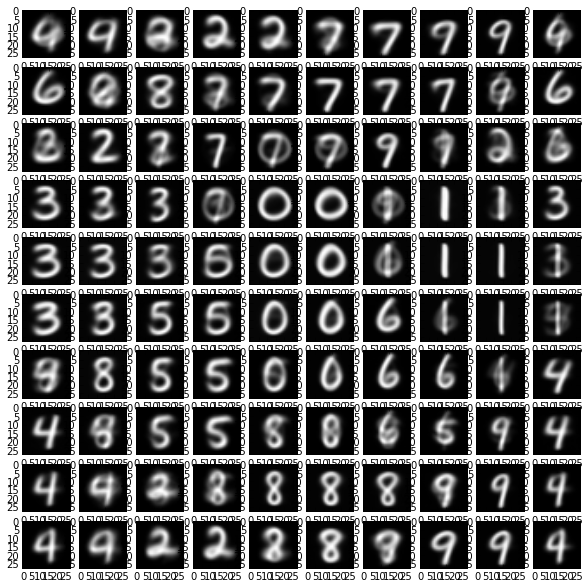

In [95]:
# SOM output with toroidal updates
showgrid(protos,10,10)

Note how shapes at the right edge of the map are now similar to shapes
in the same row at the left edge, and the same works for top and bottom too.
This is a toroidal mapping, and it doesn't have any edges.

It is called _toroidal_ because the map is topologically equivalent to the
surface of a torus.